## Training a Vision Transformer in JAX with [Keras 3.0](https://keras.io/keras_3/)
### Author: [Simone Scardapane](https://sscardapane.it/)

The recently released Keras 3.0 has reintroduced the option of working with multiple back-ends (TensorFlow, PyTorch, JAX), with the possibility of writing *platform-agnostic* code for designing and training neural networks.

In this notebook, we showcase this by implementing a simple [Vision Transformer](https://arxiv.org/abs/2010.11929) model, using PyTorch for loading and processing the dataset, an [einops](https://einops.rocks/) function for converting the images into patches, and [JAX](https://jax.readthedocs.io/) code for writing a custom training loop.

This tutorial is partly based on two guides from the Keras website ([Custom training loops in JAX](https://keras.io/guides/custom_train_step_in_jax/) and [Making new layers and models](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)), with some adaptations for the purposes of the example. We will go quickly through most components, assuming familiarity with the libraries.

>💁 If you have feedback on this tutorial, feel free to reach out!

### Step 0: Setting up the notebook

**Note**: we are using a CPU environment for simplicity. If you want a GPU environment, you will need to play a bit more with the dependencies: https://keras.io/getting_started/.

In [ ]:
# Upgrade TensorFlow to 2.16, and JAX to 0.4.20
%pip install einops tensorflow jax --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 476.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.1 MB/s eta 0:00:00


In [ ]:
# Upgrade Keras to 3.0
%pip install keras --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.1/999.1 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.1 which is incompatible.


In [ ]:
# We need to setup a backend BEFORE importing Keras.
# For this tutorial, we will use JAX, which is a good default for speed.
import os
os.environ["KERAS_BACKEND"] = "jax"

### Step 1: Data loading (PyTorch)

For this tutorial, we will use the [EuroSAT](https://github.com/phelber/EuroSAT) dataset from `torchvision`. The following is standard PyTorch code for loading and preprocessing data (see [Loading data in PyTorch](https://pytorch.org/tutorials/recipes/recipes/loading_data_recipe.html)), feel free to skip to the next section if you are familiar with it.

In [ ]:
import torch, torchvision
from torchvision.transforms import v2 as T

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
# Simple data augmentation routine, feel free to modify as you prefer.
transforms = T.Compose([
    T.RandomRotation(10),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True)
])

In [ ]:
# Disable SSL certificate checking to download the dataset, don't do this in production. :-)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
dataset = torchvision.datasets.EuroSAT('/eurosat/', download=True, transform=transforms)

100%|██████████| 94280567/94280567 [00:04<00:00, 21428652.83it/s]


Extracting /eurosat/eurosat/EuroSAT.zip to /eurosat/eurosat


In [ ]:
# Default data loader, nothing fancy
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
for xb, yb in dataloader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([16, 3, 64, 64])
torch.Size([16])


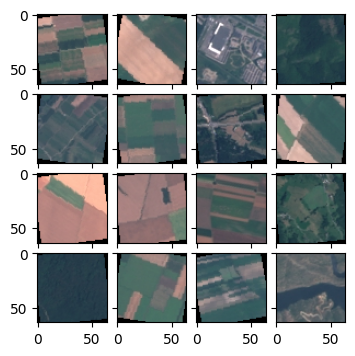

In [ ]:
# Some examples from the data loader
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  nrows_ncols=(4, 4),  axes_pad=0.1)
for ax, x in zip(grid, [x.transpose(0, 2).numpy() for x in xb]):
    ax.imshow(x)

### Step 2: Fine-tuning a ResNet-50 model (Keras)

As an example of working with a multi-backend, we fine-tune a pre-trained ResNet-50 model. Note that all code is run in JAX, even if never shown explicitly. See [this guide](https://keras.io/api/applications/resnet/) for more details about pre-trained models in Keras.

In [ ]:
from keras import Sequential
from keras import layers, losses, optimizers, metrics, applications

In [ ]:
model = Sequential([
    layers.Permute((2, 3, 1)), # Can also use channels_first in the ResNet50 model.
    applications.resnet.ResNet50(include_top=False, input_shape=(64, 64, 3)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10)
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Sanity check
model(xb).shape

(16, 10)

In [ ]:
# Make the backbone untrainable ("freezed")
model.layers[1].trainable = False
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ permute (Permute)                  │ (16, 64, 64, 3)               │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ resnet50 (Functional)              │ (16, 2, 2, 2048)              │  23,587,712 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ global_average_pooling2d           │ (16, 2048)                    │           0 │
│ (GlobalAveragePooling2D)           │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (16, 10)                      │      20,490 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile the model
model.compile(loss=losses.SparseCategoricalCrossentropy(), optimizer=optimizers.Adam())

In [ ]:
# This will take a lot without a GPU, uncomment it otherwise.
# model.fit(dataloader, epochs=1)

### Step 3: Image patchification (Keras, einops)

We now implement the embedding step of the ViT model:

<img src="https://www.sscardapane.it/assets/images/vit.png" alt="" width="35%"/>

To keep things interesting, we will use [einops](https://einops.rocks/) for making the patches, which will keep all the code framework-agnostic.

In [ ]:
from einops import rearrange

In [ ]:
# Keras ops are framework-agnostic building blocks, including a full NumPy
# reimplementation and several basic functions to build neural networks (e.g., softmax).
from keras import ops

In [ ]:
# Here, a simple einsum to move the channel dimension.
ops.einsum('b c h w -> b h w c', xb).shape

(16, 64, 64, 3)

In [ ]:
# Split the image into patches of size 8x8.
# See the einops tutorial if you are unfamiliar: https://einops.rocks/1-einops-basics/
patches = rearrange(xb, 'b c (h ph) (w pw) -> b (h w) ph pw c', ph=8, pw=8)

In [ ]:
patches.shape

torch.Size([16, 64, 8, 8, 3])

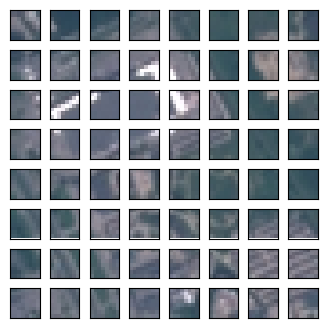

In [ ]:
# Plot the patches for a representative image.
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  nrows_ncols=(8, 8),  axes_pad=0.1)
for ax, x in zip(grid, [x.numpy() for x in patches[2]]):
    ax.imshow(x, cmap='gray')
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
class InputEmbedding(layers.Layer):
    # Define a new layer (always working in all backends). This layer will split the image into patches,
    # and add positional embeddings and class tokens.
    def __init__(self, patch_size=8, embedding_dim=32):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        # einops function to split the image into patches
        self.patchifier = lambda x: rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)

    def build(self, input_shape):
        # In Keras, it is good practice to defer initializing all parameters
        # until the shape of the input is known.
        # Compute the number of patches
        num_patches = (input_shape[1] // self.patch_size) * (input_shape[2] // self.patch_size)
        # Project each patch to the desired embedding dimension
        self.proj = layers.Dense(self.embedding_dim)
        # Initialize the positional embeddings
        self.pos_embeddings = self.add_weight(
            shape=(1, num_patches  + 1, self.embedding_dim),
            initializer="random_normal",
            trainable=True,
        )
        # Initialize the class token
        self.cls_token = self.add_weight(
            shape=(1, 1, self.embedding_dim),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, x):
        x = self.proj(self.patchifier(x))
        cls_token = ops.repeat(self.cls_token, x.shape[0], 0)
        x = ops.concatenate([cls_token, x], axis=1)
        return x + self.pos_embeddings

In [ ]:
inp_embedding = InputEmbedding()

In [ ]:
# To experiment: run the notebook again, but change the backend. Everything works!
y = inp_embedding(xb[0:5])
print(y.shape)

(5, 65, 32)


### Step 4: Define the ViT model (Keras)

This is a standard ViT model, where we combine our embedding procedure with a stack of transformer blocks. To make the tutorial more interesting, we will reimplement the basic block.

In [ ]:
from keras import Model, activations

In [ ]:
class TransformerBlock(Model):
    def __init__(self):
      super().__init__()
      # Standard transformer block with an MHA layer and an MLP.
      self.mha = layers.MultiHeadAttention(num_heads=4, key_dim=8, value_dim=16, output_shape=32)
      self.fc = Sequential([
          layers.Dense(32 * 3, activation=activations.gelu),
          layers.Dense(32)
      ])
      self.ln1 = layers.LayerNormalization()
      self.ln2 = layers.LayerNormalization()

    def call(self, x, training=False):
      h = self.ln1(x, training=training)
      x = self.mha(h, h) + x
      h = self.ln2(x, training=training)
      x = self.fc(h) + x
      return x

In [ ]:
block = TransformerBlock()

In [ ]:
block(y).shape

(5, 65, 32)

In [ ]:
class VisionTransformer(Model):
  def __init__(self):
    super().__init__()
    # Simple ViT with three transformer blocks
    self.inp_embedding = InputEmbedding()
    self.block1 = TransformerBlock()
    self.block2 = TransformerBlock()
    self.block3 = TransformerBlock()
    self.classifier = layers.Dense(10)

  def call(self, x, training=False):
    x = self.inp_embedding(x)
    x = self.block1(x, training=training)
    x = self.block2(x, training=training)
    x = self.block3(x, training=training)
    return self.classifier(x[:, 0, :])

In [ ]:
vit = VisionTransformer()

In [ ]:
vit(xb[0:5]).shape

(5, 10)

### Step 5: Training the model (JAX)

**All the code up to here was framework-independent.** We now showcase a customized training loop in JAX. You can read the [getting started](https://jax.readthedocs.io/en/latest/beginner_guide.html#beginner-guide) guide if you are unfamiliar with JAX. The core principle of the library is that everything is supposed to be a pure function (no objects, no side effects).

In [ ]:
import jax

In [ ]:
# We extract trainable and non-trainable variables from the model
# Not sure why we need the list iterator, strange bug: https://github.com/keras-team/keras/issues/18857
trainable_w = [w.value for w in vit.trainable_variables]
non_trainable_w = vit.non_trainable_variables

In [ ]:
# All Keras models / layers can be converted to pure function calls with stateless_call.
# The model is now a function taking as arguments the parameters and the input.
ypred, non_trainable_variables = vit.stateless_call(
        trainable_w, non_trainable_w, xb
    )

In [ ]:
# Sanity check
print(ypred.shape)

(16, 10)


In [ ]:
# Differently from before, we need to build the optimizer to ensure all
# internal states are correctly initialized.
optimizer = optimizers.Adam()
optimizer.build(vit.trainable_variables)
optimizer_variables = optimizer.variables

In [ ]:
loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
def compute_loss(trainable_w, non_trainable_w, xb, yb):
  # Loss function to compute the gradient. We just call the stateless variant of the method,
  # and compute the cross-entropy.
  y_pred, non_trainable_w = vit.stateless_call(
        trainable_w, non_trainable_w, xb
    )
  return loss_fn(yb, y_pred), non_trainable_w

In [ ]:
# Get another function with computes the gradients of compute_loss. By default, with has_aux they will be
# the gradients of the first argument (trainable_w).
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

In [ ]:
_ = grad_fn(trainable_w, non_trainable_w, xb, yb)

In [ ]:
# One training step as example
for xb, yb in dataloader:
    (loss, non_trainable_w), grads = grad_fn(
        trainable_w, non_trainable_w, xb, yb
    )
    trainable_w, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_w
    )
    print(f'First iteration: Loss is {loss}')
    break

First iteration: Loss is 2.758425235748291
